# Example Experiment
> Experiment using Repeated MNIST and BatchBALD vs BALD vs random sampling

This notebook ties everything together and runs an AL loop.

In [1]:
# experiment

import math
from tqdm.auto import tqdm
import torch
from torch import nn as nn
from torch.nn import functional as F

from batchbald_redux import (
    active_learning,
    batchbald,
    consistent_mc_dropout,
    joint_entropy,
    repeated_mnist,
)

Let's define our Bayesian CNN model that we will use to train MNIST.

In [2]:
# experiment


class BayesianCNN(consistent_mc_dropout.BayesianModule):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv1_drop = consistent_mc_dropout.ConsistentMCDropout2d()
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv2_drop = consistent_mc_dropout.ConsistentMCDropout2d()
        self.fc1 = nn.Linear(1024, 128)
        self.fc1_drop = consistent_mc_dropout.ConsistentMCDropout()
        self.fc2 = nn.Linear(128, num_classes)

    def mc_forward_impl(self, input: torch.Tensor):
        input = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(input)), 2))
        input = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(input)), 2))
        input = input.view(-1, 1024)
        input = F.relu(self.fc1_drop(self.fc1(input)))
        input = self.fc2(input)
        input = F.log_softmax(input, dim=1)

        return input

Grab our dataset, we'll use Repeated-MNIST. We will acquire to samples for each class for our initial training set.

In [ ]:
# experiment
import wandb
train_dataset, test_dataset = repeated_mnist.create_repeated_MNIST_dataset(num_repetitions=1, add_noise=False)

num_initial_samples = 20
num_classes = 10

initial_samples = active_learning.get_balanced_sample_indices(
    repeated_mnist.get_targets(train_dataset), num_classes=num_classes, n_per_digit=num_initial_samples / num_classes
)
for set_pool_size in [5000,2500,1000,500,20000,10000,40000]:
    wandb.init(project="ActiveLearning_RMNIST")
    wandb.run.name = f'BATCHBALD_{set_pool_size}'
    wandb.run.save()
    # experiment
    max_training_samples = 150
    acquisition_batch_size = 5
    num_inference_samples = 100
    num_test_inference_samples = 5
    num_samples = 100000

    test_batch_size = 512
    batch_size = 64
    scoring_batch_size = 128
    training_iterations = 4096 * 6

    use_cuda = torch.cuda.is_available()

    print(f"use_cuda: {use_cuda}")

    device = "cuda" if use_cuda else "cpu"

    kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **kwargs)

    active_learning_data = active_learning.ActiveLearningData(train_dataset)

    # Split off the initial samples first.
    active_learning_data.acquire(initial_samples)

    # THIS REMOVES MOST OF THE POOL DATA. UNCOMMENT THIS TO TAKE ALL UNLABELLED DATA INTO ACCOUNT!
    active_learning_data.extract_dataset_from_pool(60000-set_pool_size)

    train_loader = torch.utils.data.DataLoader(
        active_learning_data.training_dataset,
        sampler=active_learning.RandomFixedLengthSampler(active_learning_data.training_dataset, training_iterations),
        batch_size=batch_size,
        **kwargs,
    )

    pool_loader = torch.utils.data.DataLoader(
        active_learning_data.pool_dataset, batch_size=scoring_batch_size, shuffle=False, **kwargs
    )

    # Run experiment
    test_accs = []
    test_loss = []
    added_indices = []

    pbar = tqdm(initial=len(active_learning_data.training_dataset), total=max_training_samples, desc="Training Set Size")
    model = BayesianCNN(num_classes).to(device=device)
    optimizer = torch.optim.Adam(model.parameters())
    while True:


        model.train()

        # Train
        for data, target in tqdm(train_loader, desc="Training", leave=False):
            data = data.to(device=device)
            target = target.to(device=device)

            optimizer.zero_grad()

            prediction = model(data, 1).squeeze(1)
            loss = F.nll_loss(prediction, target)

            loss.backward()
            optimizer.step()

        # Test
        loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in tqdm(test_loader, desc="Testing", leave=False):
                data = data.to(device=device)
                target = target.to(device=device)

                prediction = torch.logsumexp(model(data, num_test_inference_samples), dim=1) - math.log(
                    num_test_inference_samples
                )
                loss += F.nll_loss(prediction, target, reduction="sum")

                prediction = prediction.max(1)[1]
                correct += prediction.eq(target.view_as(prediction)).sum().item()

        loss /= len(test_loader.dataset)
        test_loss.append(loss)

        percentage_correct = 100.0 * correct / len(test_loader.dataset)
        test_accs.append(percentage_correct)

        print(
            "Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)".format(
                loss, correct, len(test_loader.dataset), percentage_correct
            )
        )

        if len(active_learning_data.training_dataset) >= max_training_samples:
            break

        # Acquire pool predictions
        N = len(active_learning_data.pool_dataset)
        logits_N_K_C = torch.empty((N, num_inference_samples, num_classes), dtype=torch.double, pin_memory=use_cuda)

        with torch.no_grad():
            model.eval()

            for i, (data, _) in enumerate(tqdm(pool_loader, desc="Evaluating Acquisition Set", leave=False)):
                data = data.to(device=device)

                lower = i * pool_loader.batch_size
                upper = min(lower + pool_loader.batch_size, N)
                logits_N_K_C[lower:upper].copy_(model(data, num_inference_samples).double(), non_blocking=True)

        with torch.no_grad():
            candidate_batch = batchbald.get_batchbald_batch(
                logits_N_K_C, acquisition_batch_size, num_samples, dtype=torch.double, device=device
            )

        targets = repeated_mnist.get_targets(active_learning_data.pool_dataset)
        dataset_indices = active_learning_data.get_dataset_indices(candidate_batch.indices)

        print("Dataset indices: ", dataset_indices)
        print("Scores: ", candidate_batch.scores)
        print("Labels: ", targets[candidate_batch.indices])
        wandb.log({
                   "Num_Pool": len(active_learning_data.pool_dataset),
                   "Num_Train":len(active_learning_data.training_dataset),
                   "Test Loss": loss,
                  "Test Accuracy":percentage_correct})
   #                "Query Time":acquire_end})

        active_learning_data.acquire(candidate_batch.indices)
        added_indices.append(dataset_indices)
        pbar.update(len(dataset_indices))

wandb: Currently logged in as: hslrock (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


use_cuda: True


Test set: Average loss: 1.7408, Accuracy: 6387/10000 (63.87%)


Dataset indices:  [29019 19443 15973   890 38113]
Scores:  [1.3084943328886083, 2.366047520768497, 3.192180295742995, 3.748193732936982, 4.10920478982972]
Labels:  tensor([2, 2, 8, 3, 5])


Test set: Average loss: 1.9232, Accuracy: 6615/10000 (66.15%)


Dataset indices:  [27147 26697 30401 14779 58848]
Scores:  [1.3214334929280251, 2.4957487706802626, 3.3929356421792183, 3.9628864624363107, 4.267863110150539]
Labels:  tensor([8, 6, 8, 8, 7])


Test set: Average loss: 1.6069, Accuracy: 7162/10000 (71.62%)


Dataset indices:  [25309  6290 59158 40057 25075]
Scores:  [1.2554691554984898, 2.424318558760285, 3.322311006075897, 3.916272957906745, 4.260016335035396]
Labels:  tensor([2, 5, 3, 5, 5])


Test set: Average loss: 1.6914, Accuracy: 7049/10000 (70.49%)


Dataset indices:  [25644 43796 40494  7960 15450]
Scores:  [1.2341747659765674, 2.351434375178889, 3.244684148134965, 3.8458055945355025, 4.213104767808032]
Labels:  tensor([4, 7, 0, 2, 6])


Test set: Average loss: 1.8504, Accuracy: 7118/10000 (71.18%)


Dataset indices:  [20792 27448   327 12140 29542]
Scores:  [1.3289003540326512, 2.4338828388119906, 3.314876497102337, 3.9116116370849445, 4.268819266600202]
Labels:  tensor([9, 9, 3, 0, 4])


Test set: Average loss: 1.3286, Accuracy: 7632/10000 (76.32%)


Dataset indices:  [48548 43169  3130 45728 44701]
Scores:  [1.3589792916219237, 2.4623851305098925, 3.3602707229025275, 3.9445510898094387, 4.292359391225803]
Labels:  tensor([9, 0, 1, 0, 9])


Test set: Average loss: 1.1401, Accuracy: 7844/10000 (78.44%)


Dataset indices:  [ 9002 49656 31184 29899 57404]
Scores:  [1.2840131058055406, 2.477930281358689, 3.420777181211319, 4.028840490805578, 4.342865558703161]
Labels:  tensor([9, 9, 9, 3, 8])


Test set: Average loss: 1.3063, Accuracy: 7662/10000 (76.62%)


Dataset indices:  [27881 25273 20125 34968 11739]
Scores:  [1.2829688750336627, 2.4578707248359355, 3.4504003851877094, 4.050819689379669, 4.349052375393244]
Labels:  tensor([7, 5, 5, 8, 5])


Test set: Average loss: 0.8498, Accuracy: 8116/10000 (81.16%)


Dataset indices:  [ 2856 14367  5728  2029 22543]
Scores:  [1.334303996376883, 2.550644414989155, 3.5169310615653586, 4.077287502045462, 4.368433269461516]
Labels:  tensor([4, 3, 3, 3, 8])


Test set: Average loss: 0.8775, Accuracy: 8096/10000 (80.96%)


Dataset indices:  [10103  4909 52516 41985   866]
Scores:  [1.2629216740134126, 2.4425839602094537, 3.3604202955367137, 3.934337327347786, 4.279011266103503]
Labels:  tensor([4, 8, 6, 2, 2])


Test set: Average loss: 0.7171, Accuracy: 8364/10000 (83.64%)


Dataset indices:  [17540 27851 19524 13002 17325]
Scores:  [1.2143727371486333, 2.3306201627137573, 3.2261914586386267, 3.838880401285512, 4.210330059196226]
Labels:  tensor([1, 8, 2, 9, 4])


Test set: Average loss: 0.6475, Accuracy: 8461/10000 (84.61%)


Dataset indices:  [50546 19349 24883 19538  7762]
Scores:  [1.2896297404197077, 2.4435267517707824, 3.3766025551430907, 3.998644719966844, 4.3226261905566155]
Labels:  tensor([2, 6, 3, 8, 3])


Test set: Average loss: 0.6082, Accuracy: 8509/10000 (85.09%)


Dataset indices:  [16627 16043 37016 49064 34856]
Scores:  [1.225472203297743, 2.341741097617893, 3.2539714206862276, 3.9018224770658696, 4.262924091507157]
Labels:  tensor([2, 0, 5, 8, 2])


Test set: Average loss: 0.6093, Accuracy: 8601/10000 (86.01%)


Dataset indices:  [18656 47870 52866 53259 51354]
Scores:  [1.2792507909674438, 2.4485579709721383, 3.3840721198773625, 4.013014353386295, 4.3203349729449325]
Labels:  tensor([1, 9, 7, 2, 6])


Test set: Average loss: 0.5067, Accuracy: 8821/10000 (88.21%)


Dataset indices:  [ 4694 36151 47475 22513 19942]
Scores:  [1.2458505278695515, 2.3562710283219097, 3.2447328082321425, 3.869731417937998, 4.233178921043101]
Labels:  tensor([3, 4, 5, 7, 5])


Test set: Average loss: 0.4535, Accuracy: 8970/10000 (89.70%)


Dataset indices:  [30851 24904  1573  8645 28016]
Scores:  [1.2675415544907498, 2.3974124732432855, 3.311608919194799, 3.9553920177103086, 4.327328040848174]
Labels:  tensor([4, 1, 2, 8, 0])


Test set: Average loss: 0.4305, Accuracy: 9035/10000 (90.35%)


Dataset indices:  [ 5175 41299 34368 15276 28687]
Scores:  [1.4312329351765594, 2.6164203828168335, 3.509669919217658, 4.0614177725164495, 4.355093667498997]
Labels:  tensor([4, 3, 3, 7, 8])


Test set: Average loss: 0.4077, Accuracy: 9055/10000 (90.55%)


Dataset indices:  [ 5762 48102  7264 53106 38641]
Scores:  [1.333657941109621, 2.436208759628303, 3.342628686098744, 3.944916131960662, 4.30347354967787]
Labels:  tensor([2, 7, 9, 6, 8])


Test set: Average loss: 0.3662, Accuracy: 9107/10000 (91.07%)


Dataset indices:  [37118 22523 23628 48006 26333]
Scores:  [1.232227082133866, 2.346240528380111, 3.2954823497866483, 3.9554167000641467, 4.306928439399432]
Labels:  tensor([3, 9, 6, 6, 2])


Test set: Average loss: 0.3993, Accuracy: 9006/10000 (90.06%)


Dataset indices:  [17958 36548 59681  1293 31090]
Scores:  [1.280150259610298, 2.4394611853495514, 3.377120631175804, 3.9819723977004964, 4.3134632730291536]
Labels:  tensor([9, 4, 0, 1, 4])


Test set: Average loss: 0.3967, Accuracy: 9105/10000 (91.05%)


Dataset indices:  [49208 45439 20037 20666 23260]
Scores:  [1.2984128106817052, 2.415743901173898, 3.315940938089582, 3.9232517467664243, 4.276766239736693]
Labels:  tensor([0, 2, 8, 8, 7])


Test set: Average loss: 0.3274, Accuracy: 9144/10000 (91.44%)


Dataset indices:  [34819 44508 50366  5630 46379]
Scores:  [1.2256351735026079, 2.344727615412227, 3.277332247729798, 3.9351271770737455, 4.303428397801026]
Labels:  tensor([8, 5, 5, 1, 3])


Test set: Average loss: 0.3417, Accuracy: 9217/10000 (92.17%)


Dataset indices:  [17824 14690 44590 16692  2765]
Scores:  [1.3317654553824905, 2.5058632536940446, 3.424412368330482, 4.017506155755457, 4.342456177049042]
Labels:  tensor([9, 8, 7, 5, 0])


Test set: Average loss: 0.3655, Accuracy: 9128/10000 (91.28%)


Dataset indices:  [49859 48973 44133 27168 40636]
Scores:  [1.2513485298217046, 2.3821179995550588, 3.287552965463448, 3.9007666086988397, 4.276114015708051]
Labels:  tensor([3, 8, 2, 7, 3])


Test set: Average loss: 0.2889, Accuracy: 9255/10000 (92.55%)


Dataset indices:  [ 1642 13150 38705 31546 58390]
Scores:  [1.1974637702704867, 2.316360076167901, 3.2300384615718354, 3.8790220500449584, 4.258281968331225]
Labels:  tensor([6, 7, 7, 2, 4])


Test set: Average loss: 0.3492, Accuracy: 9163/10000 (91.63%)


Dataset indices:  [53693 51708 48975 36551 25908]
Scores:  [1.2240245580021298, 2.317935291103854, 3.2289283210210775, 3.8475957131172533, 4.240553914769201]
Labels:  tensor([4, 9, 2, 1, 6])


Test set: Average loss: 0.2791, Accuracy: 9300/10000 (93.00%)


Num_Pool,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
Num_Train,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
Test Accuracy,▁▂▃▃▃▄▅▄▅▅▆▆▆▆▇▇▇██▇██████
Test Loss,▇█▇▇█▅▅▅▃▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
Num_Pool,4855
Num_Train,145
Test Accuracy,91.63
Test Loss,0.34918


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


use_cuda: True


Test set: Average loss: 1.9236, Accuracy: 6101/10000 (61.01%)


Dataset indices:  [55010 27413  1160 25527 32658]
Scores:  [1.2808232315773616, 2.31833554854114, 3.1823258607090557, 3.757584105101886, 4.09900867520299]
Labels:  tensor([5, 2, 4, 8, 6])


Test set: Average loss: 1.7913, Accuracy: 6861/10000 (68.61%)


Dataset indices:  [19921  5499 26852 25139 50233]
Scores:  [1.2373273762590835, 2.3130534530580635, 3.189494582230913, 3.7944108311438316, 4.169218012332731]
Labels:  tensor([3, 5, 8, 2, 7])


Test set: Average loss: 1.6559, Accuracy: 7113/10000 (71.13%)


Dataset indices:  [14093  9116 32214 14202 53698]
Scores:  [1.2531925161815511, 2.3446744766423544, 3.2454200551771293, 3.8678811844950243, 4.266733297094939]
Labels:  tensor([8, 4, 5, 0, 9])


Test set: Average loss: 1.3492, Accuracy: 7557/10000 (75.57%)


Dataset indices:  [48384 20853 43704 12767 20832]
Scores:  [1.3152867314416439, 2.414258785369287, 3.2771693285225636, 3.901761263442297, 4.252898154501847]
Labels:  tensor([9, 5, 1, 9, 2])


Test set: Average loss: 1.1724, Accuracy: 7793/10000 (77.93%)


Dataset indices:  [51006  7766 57547 30322 21395]
Scores:  [1.2457020703658428, 2.381580183372719, 3.336061168827341, 3.9450971224283506, 4.290422128098587]
Labels:  tensor([0, 3, 7, 8, 8])


Test set: Average loss: 1.1503, Accuracy: 8037/10000 (80.37%)


Dataset indices:  [14063 32348 24589 54788 10044]
Scores:  [1.2980475722708804, 2.4841701326770607, 3.334427760463722, 3.909599570665412, 4.263020901047154]
Labels:  tensor([2, 5, 8, 6, 6])


Test set: Average loss: 1.1591, Accuracy: 8046/10000 (80.46%)


Dataset indices:  [33357 49792 56079 29340 36515]
Scores:  [1.2564843220248014, 2.3550694020898395, 3.236515628700166, 3.853182832496932, 4.229821943907446]
Labels:  tensor([3, 2, 2, 4, 3])


Test set: Average loss: 1.1113, Accuracy: 8124/10000 (81.24%)


Dataset indices:  [ 1870 14785 41180 58464 18106]
Scores:  [1.1984741459016734, 2.2922148525920623, 3.1660870981373, 3.793654725622206, 4.187703266233478]
Labels:  tensor([3, 4, 8, 8, 9])


Test set: Average loss: 1.0126, Accuracy: 8295/10000 (82.95%)


Dataset indices:  [27474 11256 33049 31103 27156]
Scores:  [1.225719542898922, 2.3457185342660907, 3.284534401462228, 3.905691795093208, 4.277802642503495]
Labels:  tensor([1, 4, 3, 8, 6])


Test set: Average loss: 1.0055, Accuracy: 8210/10000 (82.10%)


Dataset indices:  [50294 14815 10265 22130  9966]
Scores:  [1.2844772098036947, 2.4489775225841797, 3.3139238127133455, 3.9058262006430944, 4.256215114940529]
Labels:  tensor([6, 9, 0, 5, 0])


Test set: Average loss: 0.9875, Accuracy: 8252/10000 (82.52%)


Dataset indices:  [30885 11122 32606 50263 12594]
Scores:  [1.2857642721526172, 2.476911135880056, 3.3959694722914353, 4.0062691811406435, 4.334223719453377]
Labels:  tensor([3, 7, 2, 5, 8])


Test set: Average loss: 0.9175, Accuracy: 8491/10000 (84.91%)


Dataset indices:  [42293 19569 29731 44364 18398]
Scores:  [1.1844411060591162, 2.2450061342658962, 3.1030835454951857, 3.747277817105863, 4.156240224695264]
Labels:  tensor([9, 2, 9, 2, 4])


Test set: Average loss: 0.5843, Accuracy: 8713/10000 (87.13%)


Dataset indices:  [31029  6784 18009 15949 17208]
Scores:  [1.154089293110081, 2.1653645885829813, 3.0349258052925547, 3.6852373701250762, 4.10937960745631]
Labels:  tensor([4, 3, 9, 5, 3])


Test set: Average loss: 0.4977, Accuracy: 8859/10000 (88.59%)


Dataset indices:  [49202 25152 53884 28080 41463]
Scores:  [1.2655502091369326, 2.3051386926708926, 3.170424003673572, 3.8094709616265052, 4.22042757811451]
Labels:  tensor([5, 0, 2, 5, 8])


Test set: Average loss: 0.4753, Accuracy: 8914/10000 (89.14%)


Dataset indices:  [49589 30806 28253 50897 48272]
Scores:  [1.217881163492919, 2.30452088366287, 3.2195409762002454, 3.8683935580379263, 4.234797391526645]
Labels:  tensor([3, 8, 4, 2, 9])


Test set: Average loss: 0.4161, Accuracy: 8986/10000 (89.86%)


Dataset indices:  [  918  6466 33153 41850  2381]
Scores:  [1.1357891615151527, 2.123948878435222, 3.011044936146719, 3.6663498525780116, 4.08436318489791]
Labels:  tensor([7, 2, 7, 3, 7])


Test set: Average loss: 0.3649, Accuracy: 9183/10000 (91.83%)


Dataset indices:  [15913 33035 59423 42802 32172]
Scores:  [1.1537489835931756, 2.2162295587491148, 3.065816884029121, 3.709042892427497, 4.132205054367278]
Labels:  tensor([9, 6, 8, 9, 4])


Test set: Average loss: 0.3187, Accuracy: 9244/10000 (92.44%)


Dataset indices:  [52152 10984  3626 24633 50346]
Scores:  [1.2007843473856417, 2.270721880827658, 3.1389115445492406, 3.7685435140600823, 4.166423864048301]
Labels:  tensor([2, 3, 3, 2, 8])


Test set: Average loss: 0.3649, Accuracy: 9186/10000 (91.86%)


Dataset indices:  [56737 19334 55396 27845 14650]
Scores:  [1.1507876891320548, 2.22107065248428, 3.105617454423664, 3.748147777722866, 4.159874024143611]
Labels:  tensor([1, 7, 5, 5, 4])


Test set: Average loss: 0.3321, Accuracy: 9226/10000 (92.26%)


Dataset indices:  [56454  6808 33253 14830 25945]
Scores:  [1.220394985627412, 2.309938434535874, 3.158329150273287, 3.772476199376279, 4.178601873733738]
Labels:  tensor([0, 8, 0, 8, 1])


Test set: Average loss: 0.3193, Accuracy: 9256/10000 (92.56%)


Dataset indices:  [31558 33290 47376   635 39284]
Scores:  [1.2758166314443091, 2.3690908046819725, 3.2376735174132274, 3.8475401232444044, 4.21061617104807]
Labels:  tensor([7, 2, 6, 5, 2])


Test set: Average loss: 0.3079, Accuracy: 9262/10000 (92.62%)


Dataset indices:  [47401 26474 53116 44143  3756]
Scores:  [1.1863124389211959, 2.3068591073774973, 3.254846671157063, 3.895817327366242, 4.263529570559364]
Labels:  tensor([8, 8, 0, 2, 3])


Test set: Average loss: 0.3116, Accuracy: 9297/10000 (92.97%)


Dataset indices:  [48382 54994 44862 31594 11631]
Scores:  [1.271828887472291, 2.3924255720275256, 3.288240345866355, 3.8837064538380144, 4.256451935645919]
Labels:  tensor([8, 6, 0, 7, 5])


Test set: Average loss: 0.3162, Accuracy: 9328/10000 (93.28%)


Dataset indices:  [14468  3367  2706 57308 49933]
Scores:  [1.1374877835601036, 2.192886089756799, 3.0955777662865076, 3.729773454246306, 4.136062126253715]
Labels:  tensor([2, 0, 7, 3, 7])


Test set: Average loss: 0.3384, Accuracy: 9269/10000 (92.69%)


Dataset indices:  [ 5278 35429 54038 12059  2722]
Scores:  [1.2910927692285028, 2.43114684514223, 3.2760672156699435, 3.8600733426922433, 4.235753861830618]
Labels:  tensor([4, 4, 9, 9, 9])


Test set: Average loss: 0.3094, Accuracy: 9278/10000 (92.78%)


Dataset indices:  [55372 29701 11643    60 45925]
Scores:  [1.153455305502631, 2.2097734701978333, 3.126664357189581, 3.8209082874498765, 4.223940001858353]
Labels:  tensor([6, 3, 5, 4, 9])


Test set: Average loss: 0.2790, Accuracy: 9348/10000 (93.48%)


Num_Pool,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
Num_Train,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
Test Accuracy,▁▃▃▄▅▅▅▅▆▆▆▆▇▇▇▇██████████
Test Loss,█▇▇▆▅▅▅▄▄▄▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁
Num_Pool,2355
Num_Train,145
Test Accuracy,92.78
Test Loss,0.30943


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


use_cuda: True


Test set: Average loss: 1.5406, Accuracy: 6494/10000 (64.94%)


Dataset indices:  [27888 49149 23421 46246 52346]
Scores:  [1.2294924685317379, 2.268389630952704, 3.0854815931349355, 3.6458991556675366, 4.0010701598707445]
Labels:  tensor([2, 3, 6, 3, 4])


Test set: Average loss: 1.7761, Accuracy: 6829/10000 (68.29%)


Dataset indices:  [53832 10390 35114  7797 54194]
Scores:  [1.2876365345369671, 2.4205457099962335, 3.295430040512345, 3.8405610399698134, 4.192746520877233]
Labels:  tensor([7, 3, 5, 8, 7])


Test set: Average loss: 1.7564, Accuracy: 7062/10000 (70.62%)


Dataset indices:  [25415 58324 36215   178 23350]
Scores:  [1.2074690722474923, 2.2708107855485706, 3.1182491446282876, 3.75105167353302, 4.12355578061022]
Labels:  tensor([8, 3, 1, 2, 8])


Test set: Average loss: 1.4684, Accuracy: 7434/10000 (74.34%)


Dataset indices:  [ 3594 11549  8235 39242  1812]
Scores:  [1.1552283327755364, 2.2277472080520444, 3.1365413603085512, 3.7889448402618937, 4.172157385654944]
Labels:  tensor([9, 5, 4, 8, 4])


Test set: Average loss: 1.4258, Accuracy: 7600/10000 (76.00%)


Dataset indices:  [18929 40040 19524 58510 16499]
Scores:  [1.2547118166623479, 2.3445548449777327, 3.2921656873817193, 3.8860779362919415, 4.23777520033034]
Labels:  tensor([5, 0, 2, 0, 5])


Test set: Average loss: 1.1958, Accuracy: 7983/10000 (79.83%)


Dataset indices:  [57474 37996 47652 20268 17937]
Scores:  [1.3626602518238844, 2.411581302295296, 3.2646995079384604, 3.868302349117976, 4.219219669292475]
Labels:  tensor([3, 3, 2, 2, 8])


Test set: Average loss: 1.2824, Accuracy: 7946/10000 (79.46%)


Dataset indices:  [24623 15765 48929  9940 33217]
Scores:  [1.1920140391897796, 2.2927162560822367, 3.133103019284208, 3.7166704267975867, 4.097951252877502]
Labels:  tensor([2, 0, 0, 4, 6])


Test set: Average loss: 1.4148, Accuracy: 7881/10000 (78.81%)


Dataset indices:  [46941 57880 58543 28128 56808]
Scores:  [1.1538038613519053, 2.211614311070017, 3.069131850815288, 3.695003345834578, 4.10937712513939]
Labels:  tensor([5, 9, 8, 4, 4])


Test set: Average loss: 0.9529, Accuracy: 8241/10000 (82.41%)


Dataset indices:  [35034 20866  2076 16637  2041]
Scores:  [1.133126935965998, 2.1689158226353036, 3.050842862092778, 3.6579028779659843, 4.0904694037956215]
Labels:  tensor([6, 7, 3, 8, 9])


Test set: Average loss: 0.7921, Accuracy: 8429/10000 (84.29%)


Dataset indices:  [53979 29611 28209   304 24681]
Scores:  [1.1027421635111991, 2.1112250689669816, 3.016695443833143, 3.687104225525867, 4.109387156148385]
Labels:  tensor([8, 2, 5, 9, 0])


Test set: Average loss: 0.6618, Accuracy: 8574/10000 (85.74%)


Dataset indices:  [27880  2320 49491 34098 27226]
Scores:  [1.2253300223772414, 2.33020990667113, 3.192012522400377, 3.808269008717894, 4.183665702169206]
Labels:  tensor([2, 6, 7, 8, 9])


Test set: Average loss: 0.6375, Accuracy: 8710/10000 (87.10%)


Dataset indices:  [ 2231 34554 34685 27340 30457]
Scores:  [1.1095000747997963, 2.1304562920429104, 3.0141269310898267, 3.694280132771033, 4.1167385137121055]
Labels:  tensor([8, 8, 3, 5, 1])


Test set: Average loss: 0.5969, Accuracy: 8723/10000 (87.23%)


Dataset indices:  [ 6305  3615 35198 32068 11136]
Scores:  [1.1391666797184645, 2.1847094735960555, 3.0755178687799347, 3.7052815368738976, 4.107849283939073]
Labels:  tensor([5, 6, 2, 9, 5])


Test set: Average loss: 0.4993, Accuracy: 8883/10000 (88.83%)


Dataset indices:  [ 6291 12972 20587 29026 43416]
Scores:  [1.1494486829239647, 2.210600818769216, 3.0298783321479372, 3.6633878454039417, 4.054745427935246]
Labels:  tensor([3, 4, 3, 8, 9])


Test set: Average loss: 0.4364, Accuracy: 8995/10000 (89.95%)


Dataset indices:  [27968  9804 59433 12684  2703]
Scores:  [1.1300851810259043, 2.1160130263866868, 2.979076692254809, 3.6069343200158657, 4.029217716283856]
Labels:  tensor([9, 1, 0, 5, 9])


Test set: Average loss: 0.4355, Accuracy: 9079/10000 (90.79%)


Dataset indices:  [18671 19322 13681 33838 17269]
Scores:  [1.2168792265505741, 2.2078365770493016, 3.0610353990268524, 3.6563520285021496, 4.043868928674049]
Labels:  tensor([7, 9, 5, 7, 2])


Test set: Average loss: 0.3749, Accuracy: 9138/10000 (91.38%)


Dataset indices:  [15252 35924  8325 50728   978]
Scores:  [1.2582338224763534, 2.1749987327142524, 2.9337516692320493, 3.505221402379215, 3.9259832309778533]
Labels:  tensor([1, 8, 4, 3, 1])


Test set: Average loss: 0.3507, Accuracy: 9198/10000 (91.98%)


Dataset indices:  [15515 34845  6486 41323 38543]
Scores:  [0.9904037413259665, 1.8687776057079972, 2.6459214430053355, 3.24348160600739, 3.7045870706029973]
Labels:  tensor([8, 3, 6, 6, 0])


Test set: Average loss: 0.3741, Accuracy: 9121/10000 (91.21%)


Dataset indices:  [24180 18924 56188 27122 49591]
Scores:  [1.0032872366249805, 1.9471173771676251, 2.7127694711957284, 3.351864101964757, 3.828327148574181]
Labels:  tensor([5, 3, 2, 2, 9])


Test set: Average loss: 0.3721, Accuracy: 9198/10000 (91.98%)


Dataset indices:  [52151  8104 42227 47762  8628]
Scores:  [1.0387084954516559, 1.9763274140768896, 2.772095046364508, 3.3818911757343675, 3.7994780151493575]
Labels:  tensor([9, 5, 0, 9, 6])


Test set: Average loss: 0.3453, Accuracy: 9235/10000 (92.35%)


Dataset indices:  [34303 23526 38512 47234 44110]
Scores:  [1.002775106783619, 1.8986676523427484, 2.655193336322347, 3.2706004228906016, 3.761648717127179]
Labels:  tensor([4, 7, 5, 1, 4])


Test set: Average loss: 0.3327, Accuracy: 9250/10000 (92.50%)


Dataset indices:  [13352 34669 36434  8661 14844]
Scores:  [1.020101546391372, 1.8784641527565933, 2.67207542183304, 3.266400099752533, 3.7314398331737086]
Labels:  tensor([3, 8, 4, 8, 9])


Test set: Average loss: 0.3117, Accuracy: 9286/10000 (92.86%)


Dataset indices:  [ 6352 27696 50107  4369 47941]
Scores:  [0.833808210369201, 1.6136102293538443, 2.248553871665178, 2.7951975414458983, 3.2383288400985757]
Labels:  tensor([5, 2, 3, 3, 7])


Test set: Average loss: 0.3294, Accuracy: 9298/10000 (92.98%)


Dataset indices:  [20767 48556  5928 49398 43165]
Scores:  [0.8664858165760718, 1.636555720916843, 2.310608963070087, 2.9059306595325616, 3.3831991887390993]
Labels:  tensor([9, 7, 2, 4, 8])


Test set: Average loss: 0.3023, Accuracy: 9272/10000 (92.72%)


Dataset indices:  [25809 13594 31600 24701 49802]
Scores:  [0.8912254465599512, 1.6656752579406848, 2.3334019711008605, 2.8842589385812545, 3.32946179896826]
Labels:  tensor([3, 5, 8, 9, 6])


Test set: Average loss: 0.2837, Accuracy: 9350/10000 (93.50%)


Dataset indices:  [53903   694 30025 41478 45646]
Scores:  [0.8046130812823471, 1.5189084787346294, 2.158991559280671, 2.7434499499748286, 3.2160716024399623]
Labels:  tensor([3, 8, 6, 2, 8])


Test set: Average loss: 0.3021, Accuracy: 9363/10000 (93.63%)


Num_Pool,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
Num_Train,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
Test Accuracy,▁▂▂▃▄▅▅▄▅▆▆▆▆▇▇▇▇█▇███████
Test Loss,▇██▇▆▅▆▆▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Num_Pool,855
Num_Train,145
Test Accuracy,93.5
Test Loss,0.28369


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


use_cuda: True


Test set: Average loss: 1.9919, Accuracy: 6062/10000 (60.62%)


Dataset indices:  [28097 12527 28934 26727  7801]
Scores:  [1.2218545981429245, 2.1377484160504436, 2.9501701240997065, 3.49912376878504, 3.894834648136213]
Labels:  tensor([5, 3, 6, 5, 2])


Test set: Average loss: 1.7690, Accuracy: 6908/10000 (69.08%)


Dataset indices:  [ 1075 52635 25138 22432 15975]
Scores:  [1.157922774896274, 2.1889854447427544, 3.0643499128509295, 3.678219237434907, 4.04229138901121]
Labels:  tensor([7, 9, 2, 0, 5])


Test set: Average loss: 1.9561, Accuracy: 6921/10000 (69.21%)


Dataset indices:  [  780 42417 57523  9532 43710]
Scores:  [1.2351306007490448, 2.373471976488778, 3.225664968651862, 3.7775513393705498, 4.134993996119807]
Labels:  tensor([1, 8, 3, 9, 7])


Test set: Average loss: 1.4690, Accuracy: 7608/10000 (76.08%)


Dataset indices:  [41064 21013 39833 57315  4083]
Scores:  [1.194247471725651, 2.2524874812536053, 3.129014497158237, 3.7883782082159154, 4.134263810282075]
Labels:  tensor([8, 5, 4, 8, 8])


Test set: Average loss: 1.2409, Accuracy: 7908/10000 (79.08%)


Dataset indices:  [20436  4510 19316 18845 41438]
Scores:  [1.1273929613680445, 2.142454727339719, 2.98784799952059, 3.609899087300136, 4.02647655101552]
Labels:  tensor([2, 3, 6, 2, 2])


Test set: Average loss: 1.2030, Accuracy: 8006/10000 (80.06%)


Dataset indices:  [49567 44706  9100   274 39521]
Scores:  [1.122116938690765, 2.177527612226541, 3.0122251263900246, 3.632921092738548, 4.051187925683498]
Labels:  tensor([2, 5, 4, 6, 9])


Test set: Average loss: 0.7848, Accuracy: 8391/10000 (83.91%)


Dataset indices:  [12443 15695 17027 52679 45954]
Scores:  [1.0862580259868158, 2.091757671201289, 2.94458355216461, 3.594452541739149, 4.026373224848307]
Labels:  tensor([9, 0, 8, 3, 8])


Test set: Average loss: 0.6764, Accuracy: 8566/10000 (85.66%)


Dataset indices:  [37750 57018  2472 42526 22932]
Scores:  [1.2260677675521716, 2.168981168345026, 2.977496858943398, 3.575114514926363, 3.9893500375418487]
Labels:  tensor([5, 9, 2, 3, 0])


Test set: Average loss: 0.7202, Accuracy: 8527/10000 (85.27%)


Dataset indices:  [21758  8759 10665 26681 38892]
Scores:  [1.128716074360663, 2.182342578861081, 3.003965721179745, 3.5731680685646667, 3.9824057808837425]
Labels:  tensor([7, 8, 5, 8, 3])


Test set: Average loss: 0.6996, Accuracy: 8501/10000 (85.01%)


Dataset indices:  [58919 31114 15404  2966 31099]
Scores:  [1.08910095571377, 2.0376508470391332, 2.81576319552409, 3.437912997387363, 3.8826399906870397]
Labels:  tensor([4, 4, 6, 5, 5])


Test set: Average loss: 0.6622, Accuracy: 8531/10000 (85.31%)


Dataset indices:  [21066 14637 49012 56047  9330]
Scores:  [1.1331990979719966, 2.14292408794778, 2.9750626320533406, 3.573314774007086, 3.988078858931199]
Labels:  tensor([0, 4, 7, 3, 5])


Test set: Average loss: 0.6084, Accuracy: 8748/10000 (87.48%)


Dataset indices:  [21889 12675 19590 19322 52099]
Scores:  [1.1530528028132006, 2.202650591246269, 3.1070431574983166, 3.7128582430606087, 4.103740145338082]
Labels:  tensor([1, 4, 5, 9, 2])


Test set: Average loss: 0.6008, Accuracy: 8755/10000 (87.55%)


Dataset indices:  [10041 49555 52913 58472 18468]
Scores:  [1.0617209181230742, 2.063178983363121, 2.915074328388133, 3.5523569671756614, 3.9910575919179507]
Labels:  tensor([8, 2, 8, 2, 1])


Test set: Average loss: 0.5906, Accuracy: 8800/10000 (88.00%)


Dataset indices:  [57732 52182 10283 11248 22572]
Scores:  [1.0550504408088957, 2.0605470967610566, 2.8235789266027593, 3.402202634861262, 3.835190830077546]
Labels:  tensor([9, 0, 0, 1, 4])


Test set: Average loss: 0.6167, Accuracy: 8804/10000 (88.04%)


Dataset indices:  [58449 34716 43119 55826 49160]
Scores:  [0.9665412644041675, 1.7755357383086472, 2.498824436695224, 3.1058757277507167, 3.591838947090012]
Labels:  tensor([3, 3, 4, 7, 2])


Test set: Average loss: 0.4522, Accuracy: 8992/10000 (89.92%)


Dataset indices:  [47357 57318 36889 41373  4137]
Scores:  [0.9020294729728394, 1.7444660150415774, 2.4824989160558433, 3.082462801081925, 3.5016667513848487]
Labels:  tensor([5, 8, 7, 4, 1])


Test set: Average loss: 0.4759, Accuracy: 9031/10000 (90.31%)


Dataset indices:  [20230 11998  5973 26033 11191]
Scores:  [0.8583610060419158, 1.667287953040412, 2.3904621244549435, 2.9694430358729482, 3.4267727044350416]
Labels:  tensor([4, 8, 6, 3, 8])


Test set: Average loss: 0.4207, Accuracy: 9139/10000 (91.39%)


Dataset indices:  [37921  4803 49589  5052 43956]
Scores:  [0.8630071430961423, 1.6205566263961706, 2.2709414166705066, 2.8270344497726354, 3.271139839374527]
Labels:  tensor([0, 8, 3, 0, 7])


Test set: Average loss: 0.4229, Accuracy: 9097/10000 (90.97%)


Dataset indices:  [50734 18086 19479 26668 27934]
Scores:  [1.0333059943014953, 1.8255170192539225, 2.484756774942992, 3.0316120159268434, 3.4510641502391177]
Labels:  tensor([5, 7, 7, 7, 6])


Test set: Average loss: 0.4213, Accuracy: 9136/10000 (91.36%)


Dataset indices:  [45017   907  5659 59048 40236]
Scores:  [0.8549411202139513, 1.6035338962353656, 2.2369935205574674, 2.766878716775601, 3.2045703145020457]
Labels:  tensor([4, 2, 2, 7, 4])


Test set: Average loss: 0.3784, Accuracy: 9206/10000 (92.06%)


Dataset indices:  [39829 43268  8647  9308 46043]
Scores:  [0.9001684485182968, 1.6526411464864141, 2.2812076532610757, 2.795305476689632, 3.2392858435493186]
Labels:  tensor([9, 8, 7, 9, 6])


Test set: Average loss: 0.3494, Accuracy: 9308/10000 (93.08%)


Dataset indices:  [34058 24602 55416 27705 59507]
Scores:  [0.7920270546363144, 1.4452678145324702, 2.0226231253731024, 2.5517834969312427, 2.9758041282548366]
Labels:  tensor([3, 2, 4, 9, 5])


Test set: Average loss: 0.3279, Accuracy: 9288/10000 (92.88%)


Dataset indices:  [ 4700 53113 45584 51899 41317]
Scores:  [0.6517551040843912, 1.2523119897470913, 1.811947643918992, 2.3333625697683864, 2.7796197767590103]
Labels:  tensor([8, 7, 2, 8, 3])


Test set: Average loss: 0.2968, Accuracy: 9309/10000 (93.09%)


Dataset indices:  [16358 14250 26342 16206  8120]
Scores:  [0.7171444062415743, 1.3884311850626192, 1.9454944683598565, 2.443862866507975, 2.878932597024681]
Labels:  tensor([5, 8, 6, 4, 3])


Test set: Average loss: 0.3039, Accuracy: 9373/10000 (93.73%)


Dataset indices:  [ 5785 12900 11245 50998 45410]
Scores:  [0.7601208014858438, 1.3488049181170128, 1.885825988610927, 2.37447104244696, 2.79661359107997]
Labels:  tensor([1, 9, 9, 4, 6])


Test set: Average loss: 0.3137, Accuracy: 9379/10000 (93.79%)


Dataset indices:  [ 9924 55730 31140 25429 55592]
Scores:  [0.7631098692433296, 1.2327222580320505, 1.686000130395984, 2.0607065820764383, 2.388473626773262]
Labels:  tensor([8, 9, 3, 8, 3])


Test set: Average loss: 0.3150, Accuracy: 9363/10000 (93.63%)


Num_Pool,██▇▇▇▇▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▁▁
Num_Train,▁▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
Test Accuracy,▁▃▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
Test Loss,█▇█▆▅▅▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
Num_Pool,355
Num_Train,145
Test Accuracy,93.79
Test Loss,0.31373


wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


use_cuda: True


Test set: Average loss: 1.8667, Accuracy: 6182/10000 (61.82%)


Dataset indices:  [40492 14171 20021 34475 29353]
Scores:  [1.301160173968885, 2.386958029153588, 3.2216708986662224, 3.7888691534407437, 4.152376259627109]
Labels:  tensor([6, 5, 2, 2, 3])


Test set: Average loss: 1.6119, Accuracy: 6921/10000 (69.21%)


Dataset indices:  [ 6644 38960 26521  8180 39723]
Scores:  [1.3400138306393878, 2.482085480487195, 3.3456561129048836, 3.937489077722671, 4.276468978699767]
Labels:  tensor([5, 4, 6, 1, 4])


Test set: Average loss: 1.4287, Accuracy: 7365/10000 (73.65%)


Dataset indices:  [41263 53083 45804 38338 15104]
Scores:  [1.4289799310207567, 2.662744333600939, 3.5232268101883886, 4.052600191174158, 4.335726376526447]
Labels:  tensor([5, 3, 7, 7, 8])


Test set: Average loss: 1.4028, Accuracy: 7748/10000 (77.48%)


Dataset indices:  [44241  4767  1661 50461 21686]
Scores:  [1.310860325285058, 2.4630154105195223, 3.3886537216011776, 3.988366585247255, 4.3338631420131986]
Labels:  tensor([8, 8, 3, 7, 9])


Test set: Average loss: 1.4651, Accuracy: 7849/10000 (78.49%)


Dataset indices:  [27247  7228  3030 14573 30144]
Scores:  [1.4326232754346748, 2.650156091462887, 3.5457149301898525, 4.090252352425221, 4.384739122608883]
Labels:  tensor([0, 8, 9, 7, 9])


Test set: Average loss: 1.1354, Accuracy: 7800/10000 (78.00%)


Dataset indices:  [34252 48604  4948 31930 41180]
Scores:  [1.337147133176546, 2.5442294071472205, 3.482369262120563, 4.0524587764087805, 4.358594869031261]
Labels:  tensor([2, 0, 5, 1, 8])


Test set: Average loss: 0.9627, Accuracy: 8234/10000 (82.34%)


Dataset indices:  [49493 53170 45478 49582 52121]
Scores:  [1.2766652914907963, 2.442599323625552, 3.3987187820231917, 3.9976813677803706, 4.318952706134007]
Labels:  tensor([8, 8, 6, 2, 5])


Test set: Average loss: 1.1061, Accuracy: 8180/10000 (81.80%)


Dataset indices:  [48349 45212 38131 19998 17048]
Scores:  [1.3134934271106649, 2.4978350602799573, 3.4577463217019897, 4.061972310269391, 4.379812681664154]
Labels:  tensor([2, 5, 4, 4, 0])


Test set: Average loss: 1.0518, Accuracy: 8297/10000 (82.97%)


For this example, we are going to take two shortcuts that will reduce the performance:
* we discard most of the training set and only keep 20k samples; and
* we don't implement early stopping or epoch-wise training.

Instead, we always train by drawing 24576 many samples from the training set. This will overfit in the beginning and underfit later, but it still is sufficient to achieve 90% accuracy with 105 samples in the training set. 

In [ ]:
# hide
# experiment
test_accs

[64.75,
 68.19,
 69.0,
 65.95,
 73.85,
 73.78,
 76.59,
 79.4,
 78.45,
 79.99,
 83.43,
 88.24,
 89.86,
 87.31,
 88.02,
 88.99,
 89.43,
 90.39,
 89.94,
 88.93,
 89.93,
 92.08,
 91.15,
 91.77,
 89.94,
 91.11,
 91.43]

In [ ]:
# hide
# experiment
test_loss

[tensor(1.7354, device='cuda:0'),
 tensor(1.6224, device='cuda:0'),
 tensor(1.5370, device='cuda:0'),
 tensor(1.6557, device='cuda:0'),
 tensor(1.2134, device='cuda:0'),
 tensor(1.2532, device='cuda:0'),
 tensor(1.0284, device='cuda:0'),
 tensor(0.9561, device='cuda:0'),
 tensor(1.0075, device='cuda:0'),
 tensor(0.8437, device='cuda:0'),
 tensor(0.6996, device='cuda:0'),
 tensor(0.4628, device='cuda:0'),
 tensor(0.3793, device='cuda:0'),
 tensor(0.4368, device='cuda:0'),
 tensor(0.4417, device='cuda:0'),
 tensor(0.4158, device='cuda:0'),
 tensor(0.3878, device='cuda:0'),
 tensor(0.3673, device='cuda:0'),
 tensor(0.3998, device='cuda:0'),
 tensor(0.3837, device='cuda:0'),
 tensor(0.3500, device='cuda:0'),
 tensor(0.2903, device='cuda:0'),
 tensor(0.3312, device='cuda:0'),
 tensor(0.3256, device='cuda:0'),
 tensor(0.3435, device='cuda:0'),
 tensor(0.3339, device='cuda:0'),
 tensor(0.3222, device='cuda:0')]

In [ ]:
# hide
# experiment
added_indices

[array([42168, 23071, 56348, 40547, 47690]),
 array([56464, 47674, 19187, 51367, 19298]),
 array([45073, 36984, 44267, 52314, 29681]),
 array([  729, 28305, 28838, 22083,  5175]),
 array([58829, 37974, 20867, 50764, 34142]),
 array([24533, 33099, 31781, 28525, 39266]),
 array([12186,  7917, 36587, 23434, 57419]),
 array([ 2765, 28599, 13371, 31512, 52035]),
 array([31981, 43609, 28512, 54038, 28856]),
 array([57632, 25332, 13096, 56300, 55241]),
 array([ 1549, 15250, 54946, 10265, 10086]),
 array([52771, 16756, 19089,  1722, 35232]),
 array([ 6428, 59294,  3810, 55388,  8447]),
 array([34520, 27458, 13021, 47936,  3056]),
 array([53260, 36152, 45069, 41933, 17494]),
 array([23112, 41572, 42703, 24740, 22662]),
 array([43716, 57714, 24526, 43796, 43686]),
 array([42020, 13969, 15848, 55393, 52083]),
 array([58874, 10481, 26072, 50632, 41495]),
 array([31063,  9633, 57507, 27429, 24426]),
 array([37469, 30157, 52708, 26622, 34481]),
 array([ 7851, 47322, 18003, 39593, 16022]),
 array([ 7

In [ ]:
# hide
test_accs = [
    64.75,
    68.19,
    69.0,
    65.95,
    73.85,
    73.78,
    76.59,
    79.4,
    78.45,
    79.99,
    83.43,
    88.24,
    89.86,
    87.31,
    88.02,
    88.99,
    89.43,
    90.39,
    89.94,
    88.93,
    89.93,
    92.08,
    91.15,
    91.77,
    89.94,
    91.11,
    91.43,
]
max_training_samples = 150
acquisition_batch_size = 5
num_inference_samples = 100
num_test_inference_samples = 5
num_samples = 100000
num_initial_samples = 20
num_classes = 10

In [ ]:
# hide
# experiment
!pip install matplotlib

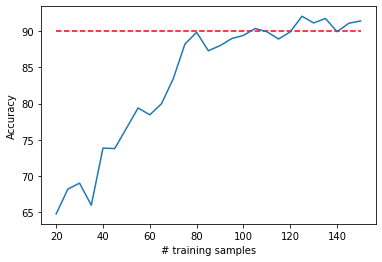

In [ ]:
# experiment
import matplotlib.pyplot as plt
import numpy as np

plt.plot(np.arange(num_initial_samples, max_training_samples + 1, acquisition_batch_size), test_accs)
plt.xlabel("# training samples")
plt.ylabel("Accuracy")
plt.hlines(90, 20, 150, linestyles="dashed", color="r")
plt.show()